In [1]:
import sys
sys.path.append("../")

from smc.sampler import SMCsampler
from smc.prior import CatalogPrior
from smc.images import ImageAttributes

import torch
# torch.cuda.is_available()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
torch.set_default_device(device)

import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
num_images = 1
img_dim = 16 # Needs to be square for now
img_width = img_dim
img_height = img_dim
max_objects = 8
psf_stdev = 3.25
background_intensity = 19200

prior = CatalogPrior(max_objects = max_objects,
                     img_height = img_height,
                     img_width = img_width,
                     min_flux = background_intensity/3.)

image_attributes = ImageAttributes(img_height = img_height,
                                   img_width = img_width,
                                   max_objects = max_objects,
                                   psf_stdev = psf_stdev,
                                   background_intensity = background_intensity)

true_counts, true_fluxes, true_locs, true_total_intensities, images = image_attributes.generate(prior, num_images)

In [3]:
for i in range(num_images):
    print(f"image {i+1}",
          "\ncount\n", true_counts[i].round().item(),
          "\ntotal flux\n", true_fluxes[i].sum().item(),
          "\nloc\n", true_locs[i].cpu().numpy(), "\n\n")

image 1 
count
 4 
total flux
 236765.71875 
loc
 [[2.1051197 3.071801 ]
 [5.8016376 9.625041 ]
 [8.813784  4.0086017]
 [5.2745442 4.4388704]
 [0.        0.       ]
 [0.        0.       ]
 [0.        0.       ]
 [0.        0.       ]] 




True count: 4
True total flux: 236765.71875
Starting the sampler...
iteration 5, temperature = 0.0016426525544375181, posterior mean count = 3.9144554138183594
iteration 10, temperature = 0.004399361088871956, posterior mean count = 3.8338751792907715
iteration 15, temperature = 0.00851447694003582, posterior mean count = 3.797929286956787
iteration 20, temperature = 0.015198806300759315, posterior mean count = 3.773214101791382
iteration 25, temperature = 0.02815091982483864, posterior mean count = 3.8350048065185547
iteration 30, temperature = 0.06102806329727173, posterior mean count = 3.8493459224700928
iteration 35, temperature = 0.144076868891716, posterior mean count = 3.889965057373047
iteration 40, temperature = 0.3148099482059479, posterior mean count = 3.980954885482788
iteration 45, temperature = 0.6571356654167175, posterior mean count = 3.9994277954101562
Done!

summary
number of SMC iterations: 48
log normalizing constant:
tensor([[          0, -2147483648],
        [   

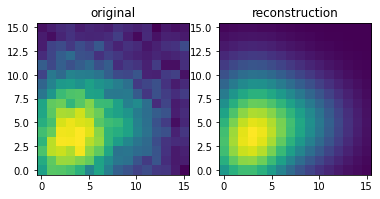

In [4]:
max_objects_smc = max_objects + 2
pad = 0
prior = CatalogPrior(max_objects_smc, img_width, img_height, background_intensity/3., pad)
smc = SMCsampler(images[0], image_attributes, prior,
                 max_objects = max_objects_smc, catalogs_per_block = 500,
                 kernel_num_iters = 100,
                 max_smc_iters = 500,
                 wastefree = True, wastefree_M = 20)

print(f"True count: {true_counts[0]}")
print(f"True total flux: {true_fluxes[0].sum()}")

smc.run(print_progress = True)
smc.summarize()